# **Transfer Learning**


## Importo file

In [ ]:
# Pacchetti che servono 
!PYTHONHASHSEED=0
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Dataset sulla macchina virtuale

copyfile('gdrive/MyDrive/FDL 22/data_puliti/TRAIN.zip', 'tr_val.zip') 

'tr_val.zip'

In [ ]:
import zipfile

zip = zipfile.ZipFile('tr_val.zip')
zip.extractall()
zip.close()

In [ ]:
copyfile('gdrive/MyDrive/FDL 22/data_puliti/TEST.zip', 'test.zip') 

'test.zip'

In [ ]:
zip = zipfile.ZipFile('test.zip')
zip.extractall()
zip.close()

## Divisione training e validation set

In [ ]:
base_path = 'TRAIN/'
num_classes = 5

In [ ]:
# Training set
train_set = keras.preprocessing.image_dataset_from_directory(base_path,
                                                 image_size=(224,224),
                                                 batch_size = 32,
                                                 label_mode='categorical',
                                                 subset='training',
                                                 validation_split=0.22,
                                                 shuffle=True,
                                                 seed=1)

Found 3237 files belonging to 5 classes.
Using 2525 files for training.


In [ ]:
# Validation set

val_set = keras.preprocessing.image_dataset_from_directory(base_path,
                                                 image_size=(224,224),
                                                 batch_size = 32,
                                                 label_mode='categorical',
                                                 subset='validation',
                                                 validation_split=0.22,
                                                 shuffle=True,
                                                 seed=1)

Found 3237 files belonging to 5 classes.
Using 712 files for validation.


In [ ]:
classes = train_set.class_names
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# MobileNetV2


Salvato come mobilenet_2.h5

Performance (overfitting):
* training set: accuracy del 99.79% (loss 0.017)
* validation set: accuracy del 89.47% (loss 0.40)
* test set: accuracy del 91.11% (loss 0.32)


## Architettura

In [ ]:
# Prima prova: Utilizzo MobileNetV2 pre-addestrata su imagnet (senza layer finali)

base_model = keras.applications.MobileNetV2(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)  

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Non deve essere riadderstrata

base_model.trainable = False

In [ ]:
# Meccanismo di early stopping

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Architettura

inputs = keras.Input(shape=(224, 224, 3))                           #immagini in input a devono essere 224x224

x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)            #trasforma i dati come richiesto per essere dati in input

x = base_model(x, training=False)                                   #pre-addestrato su imagenet         
x = keras.layers.GlobalAveragePooling2D()(x)                        #primo layer da adddestrare         

x = keras.layers.Dense(1024, activation='relu')(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)  #softmax per avere avere probabilità di ogni classe

model = keras.Model(inputs, outputs)

In [ ]:
# Mostro architettura

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
model.compile(optimizer='adam',                      
              loss='categorical_crossentropy',       
              metrics=['accuracy'])

In [ ]:
# Addestramento della rete neurale attraverso il training set

history = model.fit(train_set, 
                  epochs=20, 
                  validation_data=val_set,
                  callbacks=[callback]) # salviamo risultato nella variabile history 

Epoch 1/20
79/79 [==============================] - 22s 102ms/step - loss: 0.5103 - accuracy: 0.8242 - val_loss: 0.3448 - val_accuracy: 0.8890
Epoch 2/20
79/79 [==============================] - 7s 84ms/step - loss: 0.1827 - accuracy: 0.9358 - val_loss: 0.3497 - val_accuracy: 0.8904
Epoch 3/20
79/79 [==============================] - 7s 84ms/step - loss: 0.0997 - accuracy: 0.9683 - val_loss: 0.3464 - val_accuracy: 0.8961
Epoch 4/20
79/79 [==============================] - 9s 114ms/step - loss: 0.0364 - accuracy: 0.9937 - val_loss: 0.3838 - val_accuracy: 0.8919
Epoch 5/20
79/79 [==============================] - 7s 84ms/step - loss: 0.0212 - accuracy: 0.9960 - val_loss: 0.3780 - val_accuracy: 0.9045
Epoch 6/20
79/79 [==============================] - 7s 84ms/step - loss: 0.0169 - accuracy: 0.9976 - val_loss: 0.4007 - val_accuracy: 0.8947


Il modello utilizza quindi 6 epoche, raggiunge una accuratezza del 99.79% (loss 0.017) sul training set e del 89.47% (loss 0.40) sul validation set: overfitting.

## Salvo modello

In [ ]:
# salvo: 
model.save("mobilenet_2.h5")

## Risultati training e validation set

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

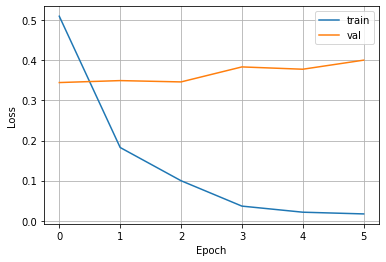

In [ ]:
# Visualizzo loss per training set e validation set
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend(['train', 'val']);
plt.grid();

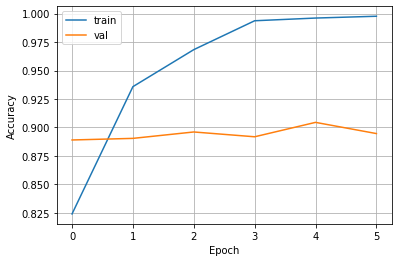

In [ ]:
# Visualizzo accuracy per training set e validation set
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.xlabel('Epoch');
plt.ylabel('Accuracy');
plt.legend(['train', 'val']);
plt.grid();

## Test set

In [ ]:
# predizione su tutto il test set

test_set = keras.preprocessing.image_dataset_from_directory('TEST/',
                                                 image_size=(224,224),
                                                 batch_size = 32,
                                                 label_mode='categorical'
                                                 )

Found 360 files belonging to 5 classes.


In [ ]:
# Accuracy del sul test set

model.evaluate(test_set)

12/12 [==============================] - 1s 58ms/step - loss: 0.3282 - accuracy: 0.9111


[0.32822421193122864, 0.9111111164093018]

Il modello raggiunge una accuracy del 91.11% (loss 0.32) sul test set.

# VGG16

Salvato come vgg_2.h5

Performance:
* training set: accuracy del 89.86% (loss 0.28)
* validation set: accuracy del 89.47% (loss 0.39)
* test set: accuracy del 89.72% (loss 0.31)


## Architettura

In [ ]:
# Utilizzo VGG16 pre-addestrata su imagnet (senza layer finali)

base_model = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)  

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# VGG16 non deve essere riadderstrata

base_model.trainable = False

In [ ]:
# Meccanismo di early stopping

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Architettura

inputs = keras.Input(shape=(224, 224, 3))                           #immagini in input a vgg16 devono essere 224x224

x = tf.keras.applications.vgg16.preprocess_input(inputs)            #trasforma i dati come richiesto per essere dati in input a vgg16

x = base_model(x, training=False)                                   #vgg16 pre-addestrato su imagenet         
x = keras.layers.GlobalAveragePooling2D()(x)                        #primo layer da adddestrare         

x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)                                    #dropout per scongiurare overfitting 

x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)                                    #dropout per scongiurare overfitting 

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)  #softmax per avere avere probabilità di ogni classe

model = keras.Model(inputs, outputs)

In [ ]:
# Mostro architettura

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               51300 

In [ ]:
model.compile(optimizer='adam',                      
              loss='categorical_crossentropy',       
              metrics=['accuracy'])

In [ ]:
# Addestramento della rete neurale attraverso il training set

history = model.fit(train_set, 
                  epochs=20, 
                  validation_data=val_set,
                  callbacks=[callback]) # salviamo risultato nella variabile history 

Epoch 1/20
79/79 [==============================] - 35s 265ms/step - loss: 3.1652 - accuracy: 0.3655 - val_loss: 0.9128 - val_accuracy: 0.6994
Epoch 2/20
79/79 [==============================] - 17s 217ms/step - loss: 1.3157 - accuracy: 0.4935 - val_loss: 0.7914 - val_accuracy: 0.7107
Epoch 3/20
79/79 [==============================] - 17s 214ms/step - loss: 1.0813 - accuracy: 0.5881 - val_loss: 0.6790 - val_accuracy: 0.7697
Epoch 4/20
79/79 [==============================] - 17s 212ms/step - loss: 0.9053 - accuracy: 0.6590 - val_loss: 0.6013 - val_accuracy: 0.7935
Epoch 5/20
79/79 [==============================] - 17s 213ms/step - loss: 0.7923 - accuracy: 0.7069 - val_loss: 0.5282 - val_accuracy: 0.8188
Epoch 6/20
79/79 [==============================] - 17s 215ms/step - loss: 0.7123 - accuracy: 0.7426 - val_loss: 0.5039 - val_accuracy: 0.8399
Epoch 7/20
79/79 [==============================] - 17s 216ms/step - loss: 0.6450 - accuracy: 0.7659 - val_loss: 0.4558 - val_accuracy: 0.8511

Il modello utilizza quindi tutte le 20 epoche, raggiunge una accuratezza del 89.86% (loss 0.28) sul training set e del 89.47% (loss 0.39) sul validation set.

## Salvo modello

In [ ]:
# salvo: 
model.save("vgg_2.h5")

## Risultati training e validation set

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

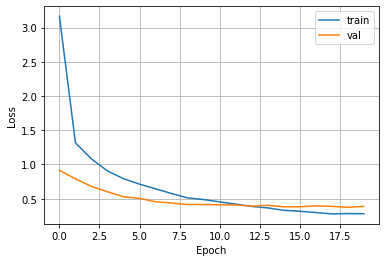

In [ ]:
# Visualizzo loss per training set e validation set
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend(['train', 'val']);
plt.grid();

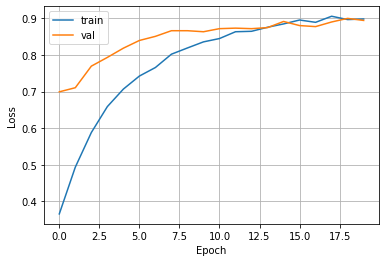

In [ ]:
# Visualizzo accuracy per training set e validation set
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend(['train', 'val']);
plt.grid();

## Test set

In [ ]:
# predizione su tutto il test set

test_set = keras.preprocessing.image_dataset_from_directory('TEST/',
                                                 image_size=(224,224),
                                                 batch_size = 32,
                                                 label_mode='categorical'
                                                 )

Found 360 files belonging to 5 classes.


In [ ]:
# Accuracy del sul test set

model.evaluate(test_set)

12/12 [==============================] - 2s 158ms/step - loss: 0.3189 - accuracy: 0.8972


[0.31891199946403503, 0.8972222208976746]

Il modello raggiunge una accuracy del 89.72% (loss 0.31) sul test set.

# Inception 

Salvato come inception_1.h5

Performance:
* training set: accuracy del 87.8% (loss 0.34)
* validation set: accuracy del 87.08% (loss 0.397)
* test set: accuracy del 87.22% (loss 0.41)


## Architettura

In [ ]:
# Utilizzo Inception pre-addestrata su imagnet (senza layer finali)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)  

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Inception non deve essere riadderstrata

base_model.trainable = False

In [ ]:
# Meccanismo di early stopping

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Architettura

inputs = keras.Input(shape=(224, 224, 3))                           #immagini in input a vgg16 devono essere 224x224

x = tf.keras.applications.inception_v3.preprocess_input(inputs)            #trasforma i dati come richiesto per essere dati in input a vgg16

x = base_model(x, training=False)                                   #vgg16 pre-addestrato su imagenet         
x = keras.layers.GlobalAveragePooling2D()(x)                        #primo layer da adddestrare         

x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)                                    #dropout per scongiurare overfitting 

x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)                                    #dropout per scongiurare overfitting 

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)  #softmax per avere avere probabilità di ogni classe

model = keras.Model(inputs, outputs)

In [ ]:
# Mostro architettura

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
model.compile(optimizer='adam',                      
              loss='categorical_crossentropy',       
              metrics=['accuracy'])

In [ ]:
# Addestramento della rete neurale attraverso il training set

history = model.fit(train_set, 
                  epochs=20, 
                  validation_data=val_set,
                  callbacks=[callback]) # salviamo risultato nella variabile history 

Epoch 1/20
79/79 [==============================] - 26s 150ms/step - loss: 1.3532 - accuracy: 0.4345 - val_loss: 0.8368 - val_accuracy: 0.7669
Epoch 2/20
79/79 [==============================] - 10s 124ms/step - loss: 0.9322 - accuracy: 0.6190 - val_loss: 0.5652 - val_accuracy: 0.8202
Epoch 3/20
79/79 [==============================] - 9s 115ms/step - loss: 0.7873 - accuracy: 0.6883 - val_loss: 0.5102 - val_accuracy: 0.8160
Epoch 4/20
79/79 [==============================] - 9s 110ms/step - loss: 0.6705 - accuracy: 0.7430 - val_loss: 0.4620 - val_accuracy: 0.8357
Epoch 5/20
79/79 [==============================] - 9s 110ms/step - loss: 0.6049 - accuracy: 0.7691 - val_loss: 0.4110 - val_accuracy: 0.8652
Epoch 6/20
79/79 [==============================] - 9s 110ms/step - loss: 0.5383 - accuracy: 0.8032 - val_loss: 0.4273 - val_accuracy: 0.8525
Epoch 7/20
79/79 [==============================] - 9s 110ms/step - loss: 0.5011 - accuracy: 0.8103 - val_loss: 0.3800 - val_accuracy: 0.8666
Epoc

Il modello utilizza quindi 14 epoche, raggiunge una accuratezza del 87.8% (loss 0.34) sul training set e del 87.08% (loss 0.397) sul validation set.

## Salvo modello

In [ ]:
# salvo: 
model.save("inception_1.h5")

## Risultati training e validation set

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

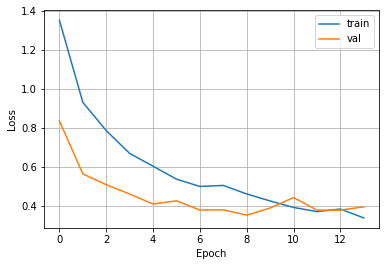

In [ ]:
# Visualizzo loss per training set e validation set
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend(['train', 'val']);
plt.grid();

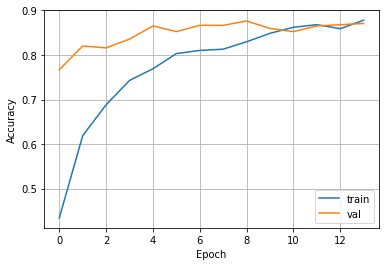

In [ ]:
# Visualizzo accuracy per training set e validation set
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.xlabel('Epoch');
plt.ylabel('Accuracy');
plt.legend(['train', 'val']);
plt.grid();

## Test set

In [ ]:
# predizione su tutto il test set 

test_set = keras.preprocessing.image_dataset_from_directory('TEST/',
                                                 image_size=(224,224),
                                                 batch_size = 32,
                                                 label_mode='categorical'
                                                 )

Found 360 files belonging to 5 classes.


In [ ]:
# Accuracy del sul test set

model.evaluate(test_set)

12/12 [==============================] - 1s 82ms/step - loss: 0.4140 - accuracy: 0.8722


[0.4139833152294159, 0.8722222447395325]

Il modello raggiunge una accuracy del 87.22% (loss 0.41) sul test set.

# AlexNet

In [ ]:
#faccio trasformazioni


data_transform = transforms.Compose([
        transforms.Resize((224, 224)),#converto tutte a 224 *224
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #normalizzazione di alexnet
])

In [ ]:
train_data = datasets.ImageFolder(root =base_path + 'data_puliti/TRAIN', transform = data_transform)
n=len(train_data)
n_val=int(0.22*n)

val_set = torch.utils.data.Subset(train_data, range(n_val)) # 0.22
train_set = torch.utils.data.Subset(train_data, range(n_val, n))  # take the rest 

test_set = datasets.ImageFolder(root =base_path + 'data_puliti/TEST', transform = data_transform)  




In [ ]:
NUMBER_CLASSES = len(train_data.classes)

In [ ]:
classes=train_data.classes

In [ ]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained = "imagenet")

#Model description
AlexNet_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
AlexNet_model.classifier[4] = torch.nn.Linear(4096,2048)

AlexNet_model.classifier[6] = torch.nn.Linear(2048, NUMBER_CLASSES) #mappo sul mio numero di classi

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cuda


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Model hyperparameters
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-05

# DataLoader parameters
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 2
                }

val_params = {'batch_size': 8,
                'shuffle': True,
                'num_workers': 2
                }

test_params = {'batch_size': 1, #batch 1 per test , metto shuffle false
                'shuffle': False,
                'num_workers': 2
                }

In [ ]:
# Calling the loaders
training_loader = torch.utils.data.DataLoader(train_set.dataset, **train_params)
validation_loader = torch.utils.data.DataLoader(val_set.dataset, **val_params)
testing_loader = torch.utils.data.DataLoader(test_set, **test_params)

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer_alex = torch.optim.Adam(params =  AlexNet_model.parameters(), lr = LEARNING_RATE)

# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

## Train (5 epochs)

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    AlexNet_model.train()
    epoch_accu = 0
    epoch_loss = 0

# 1
    for _,data in enumerate(training_loader, 0):
        images, targets = data[0].to(device), data[1].to(device)

# 2
        outputs = AlexNet_model(images)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
# 3
        
        optimizer_alex.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer_alex.step()

# 4
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = n_correct/nb_tr_examples
    print(f"Training Loss Epoch {epoch}: {epoch_loss}")
    print(f"Training Accuracy Epoch {epoch}: {epoch_accu}")

    #after each epoch calculate loss and accuracy on validation set

    arr_outputs = []
    targets = []
    predicted_class = []
    true_class = []
    total = 0
    correct = 0
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        arr_outputs.append(outputs)
        targets.append(labels)
        _, predicted = torch.max(outputs.data, 1)
        temp_pred = np.array(predicted.cpu())
        temp_lab = np.array(labels.cpu())
        for i in range(len(predicted)):
          predicted_class.append(temp_pred[i])
          true_class.append(temp_lab[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    val_loss = loss_function(torch.stack(arr_outputs).reshape(len(arr_outputs), 5), torch.stack(targets).reshape(len(targets))).item()

    print('loss', val_loss)

    print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))
    val_acc = (100 * correct / total)
    return epoch_accu, epoch_loss, val_loss, val_acc

epoch_accu_alex = []
epoch_loss_alex = []
validation_accuracy=[]
validation_loss=[]
for epoch in range(EPOCHS):
  tr_acc, tr_loss, val_loss, val_acc = train(epoch)

  epoch_accu_alex.append(tr_acc)
  epoch_loss_alex.append(tr_loss)
  validation_accuracy.append(val_acc)
  validation_loss.append(val_loss)

Training Loss Epoch 0: 0.6237772805547273
Training Accuracy Epoch 0: 0.7707754093296262
loss 0.33465173840522766
Accuracy of the network on the test images: 88.446092 %
Training Loss Epoch 1: 0.307533284690645
Training Accuracy Epoch 1: 0.8962001853568119
loss 0.20075495541095734
Accuracy of the network on the test images: 92.863763 %
Training Loss Epoch 2: 0.20652865344819463
Training Accuracy Epoch 2: 0.9249304911955515
loss 0.1400129199028015
Accuracy of the network on the test images: 95.396973 %
Training Loss Epoch 3: 0.14016433177604973
Training Accuracy Epoch 3: 0.9533518690145196
loss 0.09482681751251221
Accuracy of the network on the test images: 97.034291 %
Training Loss Epoch 4: 0.0991441484811618
Training Accuracy Epoch 4: 0.9657089898053753
loss 0.06899592280387878
Accuracy of the network on the test images: 97.713933 %


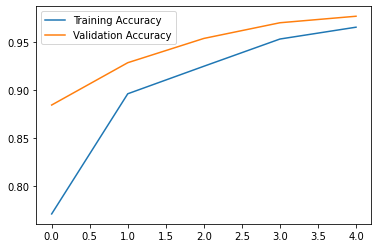

In [ ]:
# Add plot of accuracy and loss
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(EPOCHS), epoch_accu_alex, label = "Training Accuracy")
ax.plot(range(EPOCHS), (np.array(validation_accuracy)/100), label = "Validation Accuracy")
ax.legend()
plt.show()

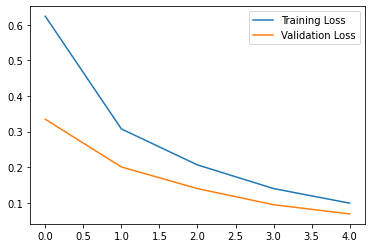

In [ ]:
# Add plot of accuracy and loss
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(EPOCHS), epoch_loss_alex, label = "Training Loss")
ax.plot(range(EPOCHS), validation_loss, label = "Validation Loss")
ax.legend()
plt.show()

## Test

In [ ]:
# Testing the model
def valid_alex(testing_loader, model):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  losses = []

  arr_outputs = []
  targets = []
  with torch.no_grad():
    for data in testing_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)

          arr_outputs.append(outputs)
          targets.append(labels)

          _, predicted = torch.max(outputs.data, 1)
          temp_pred = np.array(predicted.cpu())
          temp_lab = np.array(labels.cpu())
          for i in range(len(predicted)):
            predicted_class.append(temp_pred[i])
            true_class.append(temp_lab[i])
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  loss = loss_function(torch.stack(arr_outputs).reshape(360, 5), torch.stack(targets).reshape(360))

  print('loss', loss)

  print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))
  return predicted_class, true_class

predicted_classes_alex, true_classes_alex = valid_alex(testing_loader, AlexNet_model)

loss tensor(0.3528, device='cuda:0')
Accuracy of the network on the test images: 89.722222 %


              precision    recall  f1-score   support

           0       0.93      0.90      0.92        63
           1       0.90      0.94      0.92        90
           2       0.82      0.88      0.85        60
           3       0.94      0.89      0.91        70
           4       0.89      0.86      0.87        77

    accuracy                           0.90       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.90      0.90      0.90       360



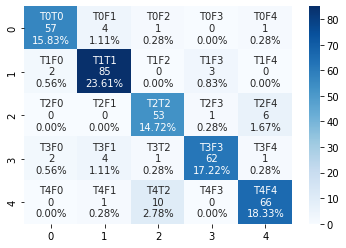

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

cf_matrix = confusion_matrix(np.transpose(true_classes_alex), np.transpose(predicted_classes_alex))
group_names = ['T0T0', 'T0F1', 'T0F2', 'T0F3', 'T0F4',
               'T1F0', 'T1T1', 'T1F2', 'T1F3', 'T1F4',
               'T2F0', 'T2F1', 'T2T2', 'T2F3', 'T2F4',
               'T3F0', 'T3F1', 'T3T2', 'T3F3', 'T3F4',
               'T4F0', 'T4F1', 'T4T2', 'T4F3', 'T4F4',
               ]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')#
print(classification_report(np.transpose(true_classes_alex), np.transpose(predicted_classes_alex)))

## extra test

In [ ]:
def get_pred(dataloader, model):
  for _,data in enumerate(dataloader, 0):

      images, targets = data[0].to(device), data[1]

      y_pred = torch.max(model(images.unsqueeze(0)), 1)[1].cpu().numpy()
      
      print('predicted:', y_pred[0], ' true:', targets)

get_pred(test_set, AlexNet_model)

predicted: 0  true: 0
predicted: 3  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 4  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 1  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 1  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 1  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 1  true: 0
predicted: 1  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 1  true: 0
predicted: 1  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: 0  true: 0
predicted: